# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0
!pip install plotly


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_in

"/Users/barbaramcgillivray/OneDrive - King's College London/Research/2022/Nexus Linguarum WG4 UC4.2/LatinISE"

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1146

We only want IntraText files:

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

553

I read the metadata file:

In [82]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df

id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22                             Thomas Aquinas: Sanctus  1254  poetry  
..                                                 ...   ...     ...  
683                 Tacitus, Publius (Gaius) Cornelius   116   prose  
684                 Tacitus, Publius (Gaius) Cornelius   116   prose  
685                 Tacitus, Publius (Gaius) Cornelius   116   prose  
686                 Tacitus, Publius (Gaius) Cornelius   116   prose  
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose  

[670 rows x 5 columns]

In [83]:
metadata_df.shape

(670, 5)

In [84]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type'], dtype='object')

In [85]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
21     1254
22     1254
       ... 
683     116
684     116
685     116
686     116
687     533
Name: date, Length: 670, dtype: int64>

In [75]:
metadata_df.head

<bound method NDFrame.head of      Selected for our study (1 or 0)     code                  era       date  \
0                                  1  LAT0142        Latina Romana         -2   
1                                  1  LAT0146        Latina Romana        -45   
2                                  1  LAT0057        Latina Romana  -29--19ca   
3                                  1  LAT0002       Latina Romana         -10   
4                                  1  LAT0284        Latina Romana   -01cent.   
..                               ...      ...                  ...        ...   
856                                0  LAT0470  Latina Mediaevalis         NaN   
857                                0  LAT0648  Latina Mediaevalis         NaN   
858                                0  LAT0661  Latina Mediaevalis         NaN   
859                                0  LAT0426        Latina Romana        NaN   
860                                0  LAT0282        Latina Romana        NaN  

Number of works per year:

In [13]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

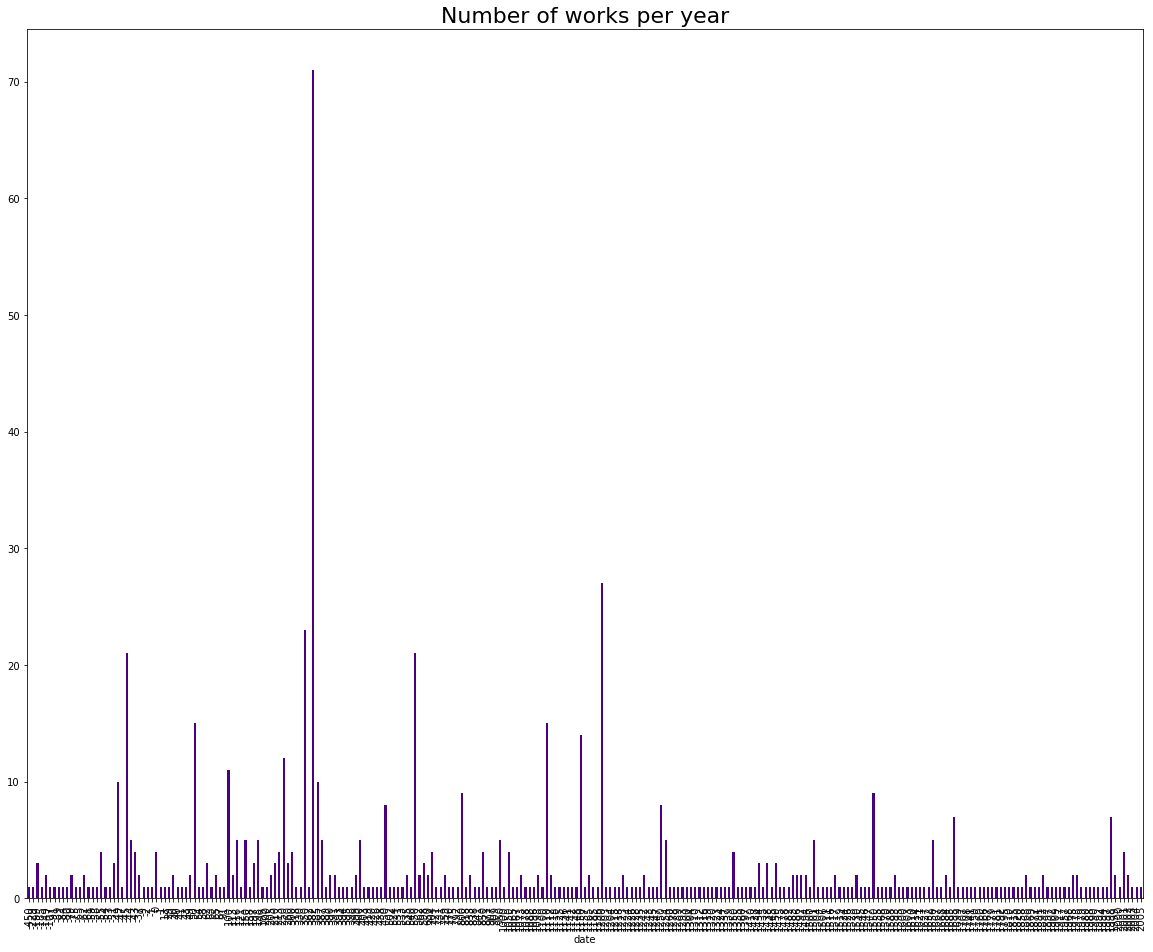

In [14]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [15]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


Define size of the time intervals:

In [16]:
size_interval = 500

So there are

In [17]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

5

time intervals.

Define the time periods and split the corpus:

In [18]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 50, 550, 1050, 1550, 2050]


Add a column to the metadata_df for the time interval:

In [19]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 50)
19      -9
34     -49
38      49
39     -45
42     -49
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 91, dtype: int64
1
range(50, 550)
18     382
20     524
23     399
24     391
37     158
      ... 
683    116
684    116
685    116
686    116
687    533
Name: date, Length: 236, dtype: int64
2
range(550, 1050)
102    800
104    800
105    800
106    800
107    800
      ... 
601    833
609    598
628    950
634    550
636    550
Name: date, Length: 66, dtype: int64
3
range(1050, 1550)
21     1254
22     1254
25     1224
26     1150
28     1517
       ... 
624    1067
625    1110
626    1110
644    1501
646    1483
Name: date, Length: 178, dtype: int64
4
range(1550, 2050)
27     2000
33     1998
35     2001
36     1992
220    1998
       ... 
641    1685
647    1550
650    1555
651    1684
652    1684
Name: date, Length: 99, dtype: int64


id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  \
18                                          Hieronymus   382  poetry   
19                               Ovidius Naso, Publius    -9  poetry   
20                                Benedictus Nursianus   524   prose   
21                             Thomas Aquinas: Sanctus  1254   prose   
22                             Thomas Aquinas: Sanctus  1254  poetry   
..                                                 ...   ...     ...   
683                 Tacitus, Publius (Gaius) Cornelius   116   prose   
684                 Tacitus, Publius (Gaius) Cornelius   116   prose   
685                 Tacitus, Publius (Gaius) Cornelius   116   prose   
686                 Tacitus, Publius (Gaius) Cornelius   116   prose   
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

    time_interval  
18             50  
19           -450  
20             50  
21           1050  
22           1050  
..            ...  
683            50  
684            50  
685            50  
686            50  
687            50  

[670 rows x 6 columns]

Visualise distribution of time intervals:

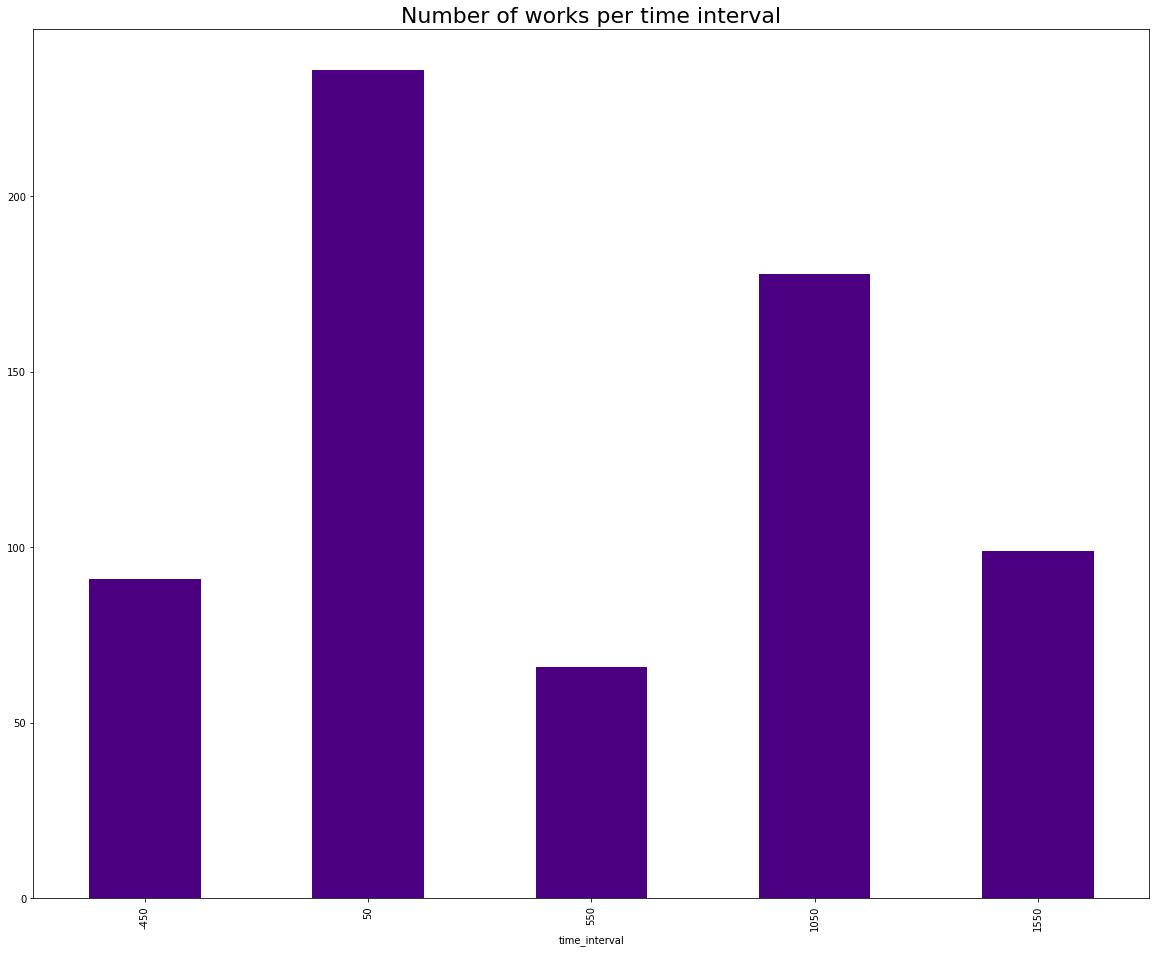

In [20]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

We may want to do something about this unbalance. See further down for the "Historical subcorpus".

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [222]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [22]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [286]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [287]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

In [288]:
metadata_df

id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  \
18                                          Hieronymus   382  poetry   
19                               Ovidius Naso, Publius    -9  poetry   
20                                Benedictus Nursianus   524   prose   
21                             Thomas Aquinas: Sanctus  1254   prose   
22                             Thomas Aquinas: Sanctus  1254  poetry   
..                                                 ...   ...     ...   
683                 Tacitus, Publius (Gaius) Cornelius   116   prose   
684                 Tacitus, Publius (Gaius) Cornelius   116   prose   
685                 Tacitus, Publius (Gaius) Cornelius   116   prose   
686                 Tacitus, Publius (Gaius) Cornelius   116   prose   
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

    time_interval  
18             50  
19           -450  
20             50  
21           1050  
22           1050  
..            ...  
683            50  
684            50  
685            50  
686            50  
687            50  

[670 rows x 6 columns]

In [289]:
corpus

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

Function for training FastText models (from Krzysztof Nowak):

In [290]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [28]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(31084184, 41666430)

Let's see what words are similar to "dies":

In [29]:
model.wv.similar_by_word('dies', 10)

[('hora', 0.6752183437347412),
 ('mensis', 0.6474769711494446),
 ('meridies', 0.6428548693656921),
 ('annus', 0.6377666592597961),
 ('quadragesima', 0.6296699643135071),
 ('triduum', 0.61091548204422),
 ('quadragesimus', 0.6022071242332458),
 ('quadriduum', 0.5993087887763977),
 ('mensium', 0.5837174654006958),
 ('ann', 0.5785283446311951)]

Let's try with different parameters:

In [30]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 361 seconds


[('diesim', 0.9309508204460144),
 ('indies', 0.8473234176635742),
 ('meridies', 0.7684506177902222),
 ('diescit', 0.7626093029975891),
 ('octies', 0.7305119633674622),
 ('novies', 0.7198655009269714),
 ('diesque', 0.7152551412582397),
 ('hora', 0.714570164680481),
 ('mensis', 0.6874949336051941),
 ('triduum', 0.6779671311378479)]

In [31]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 512 seconds


[('diesim', 0.9379062056541443),
 ('indies', 0.8583981394767761),
 ('diescit', 0.7836390733718872),
 ('meridies', 0.7503916621208191),
 ('diesque', 0.740541934967041),
 ('octies', 0.7344682812690735),
 ('novies', 0.7120219469070435),
 ('hora', 0.7067863941192627),
 ('diecula', 0.6771037578582764),
 ('sexies', 0.6731992959976196)]

I experiment with two equivalent ways to train a Fast Text model:

In [169]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(40457128, 53167930)

In [170]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

575705

In [171]:
np.allclose(model.wv['dies'], model2.wv['dies'])

True

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [32]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [33]:
time2corpus[0]

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

And the second:

In [34]:
time2corpus[1]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo'],
 ['ad',
  'tu',
  'ergo',
  'nunc',
  'ego',
  'sermo',
  'dirigo',
  'quisquis',
  'abrenuntio',
  'proprius',
  'voluntas',
  'dominus',
  'Christus',
  'verus',
  'rex',
  'militaturus',
  'oboedientia',
  'fortis',
  'atque',
  'praeclarus',
  'arma',
  'sumo'],
 ['in',
  'primus',
  'ut',
  'quisquis',
  'ago',
  'inchoas',
  'bonus',
  'ab',
  'is',
  'perficio',
  'instantissima',
  'oratio',
  'deposco',
  'ut',
  'quis#2',
  'nos',
  'iam',
  'in',
  'filius',
  'dignor',
  'sum',
  'numerus',
  'computo',
  'non',
  'debeo',
  'aliquando',
  'de',
  'malus',
  'actus',
  'noster',
  'contristo'],
 ['ita',
  'enim',
  'is'

And the third:

In [35]:
time2corpus[2]

[['conflictus',
  'VERIS',
  'et',
  'HIEMIS',
  'convenio',
  'subito',
  'cunctus',
  'de',
  'mons',
  'altus',
  'pastor',
  'pecudum',
  'vernalis',
  'lux',
  'sub',
  'umbra',
  'arboreus',
  'pariter',
  'laetus',
  'celebro',
  'Camena'],
 ['adsum',
  'et',
  'iuvenis',
  'Dafnis',
  'seniorque',
  'Palemon',
  'omnis',
  'hic',
  'cuculus',
  'laus',
  'canto',
  'paro#2'],
 ['ver',
  'quoque',
  'florigero',
  'succingo',
  'stemmate',
  'venio',
  'frigidus',
  'venio',
  'hiem(p)s',
  'rigida',
  'hirsutus',
  'capillus'],
 ['hic', 'certamen', 'sum', 'cuculus', 'de', 'carmen', 'grandis'],
 ['ver', 'prior', 'adlusit', 'terni', 'modulamine', 'versus'],
 ['Ver', 'opto', 'meus', 'venio', 'cuculus', 'carus', 'alo'],
 ['omnis',
  'iste',
  'solo',
  'fio',
  'gratus',
  'hospes',
  'in',
  'tectum',
  'modulor',
  'rutilus',
  'bonus',
  'carmen',
  'rostrum'],
 ['hiem(p)s',
  'tum',
  'glacialis',
  'hiem(p)s',
  'respondeo',
  'vox',
  'severus',
  'non',
  'venio',
  'cuculus

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

Start with the first subcorpus:

In [36]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 61 seconds


[('meridies', 0.9163129329681396),
 ('abies', 0.7936743497848511),
 ('sies', 0.7729646563529968),
 ('rabies', 0.7646446824073792),
 ('annuo', 0.7210932374000549),
 ('series', 0.7157571911811829),
 ('diesque', 0.7051329016685486),
 ('annuum', 0.7037642598152161),
 ('planities', 0.653698742389679),
 ('sanies', 0.6453130841255188)]

In [37]:
print_vocab(model, 10)

word #0/12031 is sum
word #1/12031 is et
word #2/12031 is in
word #3/12031 is quis#2
word #4/12031 is is
word #5/12031 is cum
word #6/12031 is non
word #7/12031 is hic
word #8/12031 is ad


I now check the similar words to "sum":

In [38]:
model.wv.similar_by_word('sum', 10)

[('sume', 0.8416870832443237),
 ('asum', 0.8006221652030945),
 ('sumne', 0.7785760164260864),
 ('adsum', 0.7509841322898865),
 ('ausum', 0.72687828540802),
 ('sumo', 0.725217342376709),
 ('desum', 0.7057944536209106),
 ('Thapsum', 0.7038236856460571),
 ('Salsum', 0.7017993330955505),
 ('Chersonesum', 0.7004284262657166)]

I now train one model for each time interval:

In [39]:
len(time2corpus)

6

In [40]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    if len(time2corpus[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=4, min_count=5, workers=1, seed=1,hashfxn=hash)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t])
        model.train(corpus_iterable=time2corpus[t], total_examples=len(time2corpus[t]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
3
4
It has taken 676 seconds, or  11 minutes


Let's check some models:

In [41]:
print_vocab(models[0], 20)

word #0/12031 is sum
word #1/12031 is et
word #2/12031 is in
word #3/12031 is quis#2
word #4/12031 is is
word #5/12031 is cum
word #6/12031 is non
word #7/12031 is hic
word #8/12031 is ad
word #9/12031 is ut
word #10/12031 is ab
word #11/12031 is quod
word #12/12031 is si
word #13/12031 is omnis
word #14/12031 is ex
word #15/12031 is atque
word #16/12031 is se
word #17/12031 is res
word #18/12031 is quam#4


In [42]:
models[0].wv.similar_by_word('dies', 10)

[('meridies', 0.8714439272880554),
 ('sies', 0.7241136431694031),
 ('abies', 0.7221601605415344),
 ('diesque', 0.7073634266853333),
 ('rabies', 0.658245325088501),
 ('annuum', 0.620093047618866),
 ('sanies', 0.6032583117485046),
 ('series', 0.5970252752304077),
 ('annuo', 0.5896868705749512),
 ('annus', 0.5853093862533569)]

In [43]:
print_vocab(models[1], 20)

word #0/20026 is et
word #1/20026 is sum
word #2/20026 is in
word #3/20026 is quis#2
word #4/20026 is is
word #5/20026 is non
word #6/20026 is ab
word #7/20026 is hic
word #8/20026 is ut
word #9/20026 is ad
word #10/20026 is cum
word #11/20026 is si
word #12/20026 is quod
word #13/20026 is sed
word #14/20026 is ex
word #15/20026 is ille
word #16/20026 is atque
word #17/20026 is omnis
word #18/20026 is ipse


In [44]:
models[1].wv.similar_by_word('dies', 10)

[('meridies', 0.7701682448387146),
 ('octies', 0.7644561529159546),
 ('fies', 0.7439697980880737),
 ('novies', 0.7115722894668579),
 ('hora', 0.666756808757782),
 ('abies', 0.6411404609680176),
 ('quadragies', 0.6374448537826538),
 ('series', 0.6277113556861877),
 ('annus', 0.620319128036499),
 ('requies', 0.6200743913650513)]

In [45]:
models[4].wv.similar_by_word('dies', 10)

[('meridies', 0.8791937232017517),
 ('novies', 0.7960880994796753),
 ('annulo', 0.7322573661804199),
 ('annuo', 0.7219036221504211),
 ('hebdomada', 0.7134909629821777),
 ('hebdomades', 0.7075924277305603),
 ('diesque', 0.7024726271629333),
 ('annus', 0.7013199329376221),
 ('hebdomadae', 0.6898954510688782),
 ('hora', 0.6856685280799866)]

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [46]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [47]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [48]:
smart_procrustes_align_gensim(models[2], models[0])

5352 5352
5352 5352
['sum', 'et', 'in', 'quis#2', 'is', 'cum', 'hic', 'ad', 'non', 'ut', 'ab', 'quod', 'omnis', 'ille', 'se', 'si', 'atque', 'ex', 'suus', 'sed', 'de', 'ipse', 'dico#2', 'quam#4', 'res', 'facio', 'possum', 'aut', '?', "'", 'multus', 'per', 'habeo', 'ego', 'alius', 'enim', 'autem', 'video', 'etiam', 'qui', 'Romanus', 'rex', 'nec', 'idem', 'verus', 'magnus', 'quo', 'ne#2', 'dies', 'tu', 'locus', 'do', 'homo', 'primus', 'pars', 'unus', 'ita', 'tempus', 'neque', 'causa', 'venio', 'iam', 'modus', 'bellum', 'consul', 'tamen', 'deus', 'annus', 'quidem', 'vel', 'urbs', 'nihil', '-', 'noster', 'nos', 'quidam', 'quia', 'bonus', 'quoque', 'animus', 'pro', 'exercitus', 'hostis', 'tum', 'inter', 'publicus', 'tantus', 'ago', 'aliquis', 'nullus', 'pater', 'post', 'mitto', 'vir', 'ubi', 'ante', 'duo', 'vos', 'fio', 'filius', 'senatus', 'accipio', 'genus', 'civitas', 'castrum', '[', ']', 'tuus', 'meus', 'deinde', 'nomen', 'alter', 'nisi', 'vita', 'corpus', 'populus', 'sine', 'volo#1', '

I align all models:

In [49]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

5267 5267
5267 5267
['sum', 'et', 'in', 'quis#2', 'is', 'non', 'ab', 'hic', 'ut', 'cum', 'ad', 'si', 'quod', 'sed', 'ex', 'ille', 'omnis', 'atque', 'se', 'suus', 'ipse', 'de', 'dico#2', 'quam#4', 'possum', 'facio', 'aut', '?', 'res', 'per', 'alius', 'vel', 'nec', 'habeo', 'etiam', 'enim', 'multus', 'qui', 'ego', 'autem', 'video', "'", 'idem', 'deus', 'tu', 'imperator', 'do', 'ne#2', 'quo', 'verus', 'ita', 'pars', 'locus', 'homo', 'magnus', 'iam', 'unus', 'tamen', 'primus', 'dies', 'causa', 'modus', 'tempus', 'neque', 'quidem', 'nos', 'quidam', 'rex', 'quoque', 'bonus', 'pro', 'noster', 'bellum', 'inter', 'pater', 'Romanus', 'post', 'quia', 'filius', 'venio', 'nihil', '-', 'nullus', 'tantus', 'aliquis', 'nomen', 'urbs', 'ago', 'animus', 'annus', 'tuus', 'debeo', 'fio', 'corpus', 'nisi', 'accipio', 'sine', 'publicus', 'apud', 'ante', 'duo', 'ubi', 'parvus', 'lex', 'verbum', 'solus', 'genus', 'miles', 'vir', 'sic', 'meus', 'exercitus', 'volo#1', 'iste', 'namque', 'D', 'consul', 'sive', 'm

5005 5005
5005 5005
['sum', 'et', 'in', 'quis#2', 'is', 'non', 'hic', 'ad', 'quod', 'ut', 'ab', 'cum', 'dico#2', 'de', 'ille', 'omnis', 'si', 'ipse', 'sed', 'suus', 'se', 'ex', 'possum', 'quam#4', "'", 'per', 'vel', 'alius', 'facio', 'deus', 'atque', 'habeo', 'homo', '?', 'multus', 'autem', 'enim', 'nec', 'ego', 'qui', 'res', 'video', 'idem', 'etiam', 'quia', 'aut', 'tu', 'verus', 'noster', 'quidam', 'unus', 'nos', 'dominus', 'ita', 'aliquis', 'primus', 'tamen', 'quo', 'bonus', 'modus', 'pars', 'sicut', 'quidem', 'tantus', 'rex', 'nullus', 'pro', 'locus', 'sic', 'do', '-', ']', 'magnus', 'nomen', 'pater', '[', 'iam', 'fio', 'ne#2', 'dies', 'filius', 'tempus', 'quoque', 'solus', 'tuus', 'nihil', 'iste', 'nisi', 'secundum', 'tam', 'ergo', 'inter', 'corpus', 'meus', 'genus', 'unde', 'sanctus', 'sive', 'causa', 'debeo', 'vir', 'ubi', 'venio', 'princeps', 'ago', 'neque', 'igitur', 'scilicet', 'urbs', 'verbum', 'volo#1', 'totus#2', 'accipio', 'ratio', 'pono', 'vita', 'post', 'duo', 'alter', 

4702 4702
4702 4702
['et', 'sum', 'in', 'quis#2', 'is', 'non', 'hic', 'ad', 'ut', 'ab', 'quod', 'cum', 'de', 'ille', 'dico#2', 'omnis', 'suus', 'si', 'ipse', 'se', 'sed', 'ex', 'possum', 'vel', 'atque', 'per', 'deus', 'quam#4', 'facio', 'alius', 'ego', 'habeo', '?', 'autem', "'", 'multus', 'homo', 'enim', 'qui', 'res', 'nec', 'idem', 'aut', 'etiam', 'video', 'dominus', 'tu', 'verus', '-', 'noster', 'nos', 'unus', 'quia', 'tuus', 'quidam', 'rex', 'pro', 'meus', 'ita', 'do', 'filius', 'dies', 'quo', 'primus', 'pars', 'aliquis', 'tamen', 'locus', 'bonus', 'modus', 'magnus', 'tantus', 'quidem', 'sicut', 'pater', 'sive', 'iam', 'tempus', 'nisi', 'nullus', 'ne#2', 'nomen', 'sic', 'inter', 'fio', 'debeo', 'quoque', 'causa', 'ago', 'solus', 'sanctus', 'vita', ')', 'nihil', 'venio', 'ergo', 'vir', 'terra', 'verbum', 'iste', 'vos', 'secundum', ']', 'ratio', 'corpus', 'fides', 'tam', '[', 'neque', 'genus', 'ubi', 'proprius', 'animus', 'super', '(', 'totus#2', 'princeps', 'opus', 'lex', 'audio', '

5005 5005
5005 5005
['sum', 'et', 'in', 'quis#2', 'is', 'non', 'ab', 'hic', 'ut', 'cum', 'ad', 'quod', 'si', 'sed', 'ex', 'ille', 'omnis', 'atque', 'suus', 'se', 'de', 'dico#2', 'ipse', 'quam#4', 'possum', 'facio', '?', 'aut', 'res', 'per', 'alius', 'habeo', 'vel', 'nec', 'etiam', 'enim', 'multus', 'ego', 'qui', "'", 'autem', 'video', 'deus', 'idem', 'tu', 'do', 'homo', 'ne#2', 'quo', 'verus', 'ita', 'pars', 'magnus', 'locus', 'unus', 'imperator', 'primus', 'dies', 'iam', 'tamen', 'modus', 'nos', 'quidam', 'causa', 'tempus', 'rex', 'quidem', 'neque', 'noster', 'bonus', 'quoque', 'quia', 'pro', 'pater', 'inter', 'Romanus', 'nihil', 'aliquis', 'bellum', 'venio', 'tantus', 'post', 'nullus', 'filius', '-', 'nomen', 'urbs', 'fio', 'tuus', 'ago', 'annus', 'nisi', 'corpus', 'animus', 'debeo', 'accipio', 'ubi', 'sine', 'duo', 'ante', 'publicus', 'vir', 'genus', 'solus', 'sic', 'apud', 'parvus', 'meus', 'iste', 'lex', 'verbum', '[', 'exercitus', 'volo#1', 'miles', 'tam', ']', 'consul', 'vos', '

4702 4702
['sum', 'et', 'in', 'quis#2', 'is', 'non', 'ab', 'hic', 'ut', 'cum', 'ad', 'quod', 'si', 'sed', 'ille', 'ex', 'omnis', 'atque', 'suus', 'de', 'se', 'dico#2', 'ipse', 'quam#4', 'possum', 'facio', '?', 'res', 'aut', 'per', 'alius', 'habeo', 'vel', 'nec', 'enim', 'etiam', 'ego', 'multus', 'qui', "'", 'autem', 'deus', 'video', 'idem', 'tu', 'do', 'homo', 'quo', 'verus', 'ne#2', 'unus', 'ita', 'pars', 'magnus', 'locus', 'nos', 'primus', 'dies', 'tamen', 'quidam', 'modus', 'iam', 'rex', 'imperator', 'noster', 'causa', 'tempus', 'quidem', 'quia', 'bonus', 'neque', 'quoque', 'pro', 'pater', 'inter', 'aliquis', 'nihil', '-', 'tantus', 'Romanus', 'venio', 'filius', 'bellum', 'nullus', 'tuus', 'post', 'nomen', 'fio', 'ago', 'nisi', 'urbs', 'corpus', 'debeo', 'annus', 'animus', 'ubi', 'accipio', 'vir', 'sine', 'meus', 'duo', 'ante', 'solus', 'sic', 'genus', 'dominus', 'iste', 'publicus', 'parvus', 'apud', 'verbum', 'sive', 'lex', '[', ']', 'tam', 'volo#1', 'vos', 'exercitus', 'nunc', 'vi

Now the models have been aligned and have the same vocabulary:

In [50]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 4702
1 4702
2 4702
3 4702
4 4702


# Semantic change with cosine similarity

In [51]:
intervals

[-450, 50, 550, 1050, 1550, 2050]

In [52]:
models

I define a function that, given a reference step (either "first" or "last), it returns the time intervals' range to be used to compare models against this reference step:

In [322]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [323]:
find_reference_intervals("first", intervals)

0

In [324]:
find_reference_intervals("last", intervals)

24

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [328]:
def cosine_similarity(word, t, reference_step, models, intervals):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] == '':
        print("Model of reference interval is empty!")
    else:
        if models[t] != '':
            #print(t, word)
            sc = 1-spatial.distance.cosine(models[t].wv[word], models[reference_interval_index].wv[word])
    return sc

In [329]:
cosine_similarity("sum", 4, "last", models, intervals)

IndexError: list index out of range

In [330]:
cosine_similarity("sum", 4, "first", models, intervals)

-0.0667952373623848

In [331]:
models[4]

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time inetrvals, and stores this in the dataframe cosine_similarity_df:

In [346]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    print(reference_interval_index)
    if models[reference_interval_index] != '' and models[time_interval_index] != '':
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].wv.get_vecattr(w, "count"),
            models[time_interval_index].wv.get_vecattr(w, "count"),
            cosine_similarity(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].wv.index_to_key), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [335]:
cosine_similarity_dataframe("last", 0, models, intervals)

24


IndexError: list index out of range

In [336]:
cosine_similarity_dataframe("last", 1, models, intervals)

24


IndexError: list index out of range

Visualise the distribution of the semantic similarity scores with a histogram:

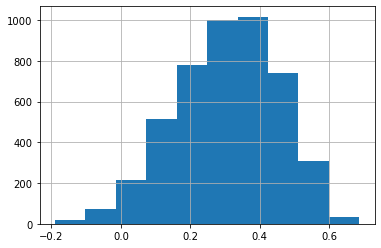

In [63]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [ ]:
intervals

In [ ]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
for i in range(len(models)-1):
    #print(reference_interval_index)
    #print("Interval", str(range_intervals[i]))
    #print((list(range_intervals)))
    print("Interval", str(range_intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models, intervals)
    if i == 0:
        time_series_df = df
        col_i = "interval-"+str(0)
        time_series_df[col_i] = [0 for w in models[reference_interval_index].wv.index_to_key]
        col_n = "neighbours_ref-"+reference_step
        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
    else:
        #time_series_df = time_series_df, df.iloc[:,-2:]
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(tmp_df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
        
    #print(time_series_df)
    
time_series_df

In [ ]:
time_series_df.columns

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

In [ ]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

In [ ]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
               ]].iloc[0]

In [ ]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [ ]:
plt.scatter([0,1,2,3], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [ ]:
time_series_df.columns

In [ ]:
time_series_df

In [ ]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1

List of socio-political terms:

In [ ]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [ ]:
time_series_df_socpol = time_series_df1[time_series_df1['Word'].isin(socio_political_terms)]
time_series_df_socpol

In [ ]:
for i in range(len(socio_political_terms)):
    plt.scatter([0,1,2,3], 
            time_series_df_socpol[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
                           ]].iloc[i])
plt.show()

In [387]:
px.line(time_series_df_socpol)

## Historical subcorpus

I select by time period before 800CE and historical genre:

In [130]:
selected_texts = ['LAT0142', 'LAT0241', 'LAT0529', 'LAT0172', 'LAT0123', 'LAT0134', 'LAT0849', 'LAT0148', 'LAT0325', 'LAT0278', 'LAT1040', 'LAT1042', 'LAT0111', 'LAT0054', 'LAT0201', 'LAT0896', 'LAT0959', 'LAT0115', 'LAT0612', 'LAT0776', 'LAT0850', 'LAT0886', 'LAT0121', 'LAT0726', 'LAT0878', 'LAT0768', 'LAT0410', 'LAT0791', 'LAT0196', 'LAT0906', 'LAT0783', 'LAT0909']
selected_texts = ['IT-'+f for f in selected_texts]
selected_texts

['IT-LAT0142',
 'IT-LAT0241',
 'IT-LAT0529',
 'IT-LAT0172',
 'IT-LAT0123',
 'IT-LAT0134',
 'IT-LAT0849',
 'IT-LAT0148',
 'IT-LAT0325',
 'IT-LAT0278',
 'IT-LAT1040',
 'IT-LAT1042',
 'IT-LAT0111',
 'IT-LAT0054',
 'IT-LAT0201',
 'IT-LAT0896',
 'IT-LAT0959',
 'IT-LAT0115',
 'IT-LAT0612',
 'IT-LAT0776',
 'IT-LAT0850',
 'IT-LAT0886',
 'IT-LAT0121',
 'IT-LAT0726',
 'IT-LAT0878',
 'IT-LAT0768',
 'IT-LAT0410',
 'IT-LAT0791',
 'IT-LAT0196',
 'IT-LAT0906',
 'IT-LAT0783',
 'IT-LAT0909']

In [131]:
#metadata_df_sel = pd.read_csv(os.path.join(dir_in, 'Metadata_selected_corpus.csv'), sep = ",")
#metadata_df_sel = metadata_df_sel[(metadata_df_sel['Selected for our study (1 or 0)'] == 1)
#                          & (metadata_df_sel['historical texts'] == 1)]
metadata_df_sel  = metadata_df[(metadata_df['id'].isin(selected_texts))]
metadata_df_sel.shape

(27, 6)

In [132]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose            50  
69           Plinius Gaius, Cecilius Secundus   100  prose            50  
72                                  Eutropius   350  prose            50  
78                       Ammianus Marcellinus   362  prose            50  
89                     Cicero, Marcus Tullius   -55  prose          -450  
97                              Livius, Titus    -1  prose          -450  
98                 Velleius Paterculus, Caius    29  prose          -450  
118                                  Iordanes   550  prose           550  
120                 Iustinus Iunianus, Marcus   250  prose            50  
142                         [Auctor incertus]   -49  prose          -450  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose          -450  
182                    Curtius Rufus, Quintus    50  prose            50  
236                        Severus, Sulpicius   403  prose            50  
382                        Severus, Sulpicius   350  prose            50  
451                                Hieronymus   390  prose            50  
472                      Augustinus, Aurelius   419  prose            50  
478                       Hydatius Lemicensis   350  prose            50  
482                      Gregorius Turonensis   550  prose           550  
490                         Marcellinus Comes   550  prose           550  
535                     Actorius Naso, Marcus   -49  prose          -450  
536        Auctor incertus (Aurelius Victor?)   350  prose            50  
551                                Hieronymus   400  prose            50  
557                                  Ablabius   330  prose            50  
563              Gargilius Martialis, Quintus   260  prose            50  
572                                  Iordanes   550  prose           550  
575            Isidorus Hispalensis Episcopus   598  prose           550  
611                     Cor

Define size of the time intervals:

In [133]:
size_interval = 100

So there are

In [134]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

25

time intervals.

Add a column to the metadata_df for the time interval:

In [137]:
metadata_df_sel['time_interval'] = ""
for t in range(len(intervals)-1):
    #print(t)
    #print(range(intervals[t],intervals[t+1]))
    metadata_df_sel_t = metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1]))]
    #print(metadata_df_sel_t.date)
    metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
    #print(intervals[t])
metadata_df_sel

<ipython-input-137-fdf9a07fb554>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_sel['time_interval'] = ""
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose            50  
69           Plinius Gaius, Cecilius Secundus   100  prose            50  
72                                  Eutropius   350  prose           350  
78                       Ammianus Marcellinus   362  prose           350  
89                     Cicero, Marcus Tullius   -55  prose          -150  
97                              Livius, Titus    -1  prose           -50  
98                 Velleius Paterculus, Caius    29  prose           -50  
118                                  Iordanes   550  prose           550  
120                 Iustinus Iunianus, Marcus   250  prose           250  
142                         [Auctor incertus]   -49  prose           -50  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose           -50  
182                    Curtius Rufus, Quintus    50  prose            50  
236                        Severus, Sulpicius   403  prose           350  
382                        Severus, Sulpicius   350  prose           350  
451                                Hieronymus   390  prose           350  
472                      Augustinus, Aurelius   419  prose           350  
478                       Hydatius Lemicensis   350  prose           350  
482                      Gregorius Turonensis   550  prose           550  
490                         Marcellinus Comes   550  prose           550  
535                     Actorius Naso, Marcus   -49  prose           -50  
536        Auctor incertus (Aurelius Victor?)   350  prose           350  
551                                Hieronymus   400  prose           350  
557                                  Ablabius   330  prose           250  
563              Gargilius Martialis, Quintus   260  prose           250  
572                                  Iordanes   550  prose           550  
575            Isidorus Hispalensis Episcopus   598  prose           550  
611                     Cor

In [138]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Visualise distribution of time intervals:

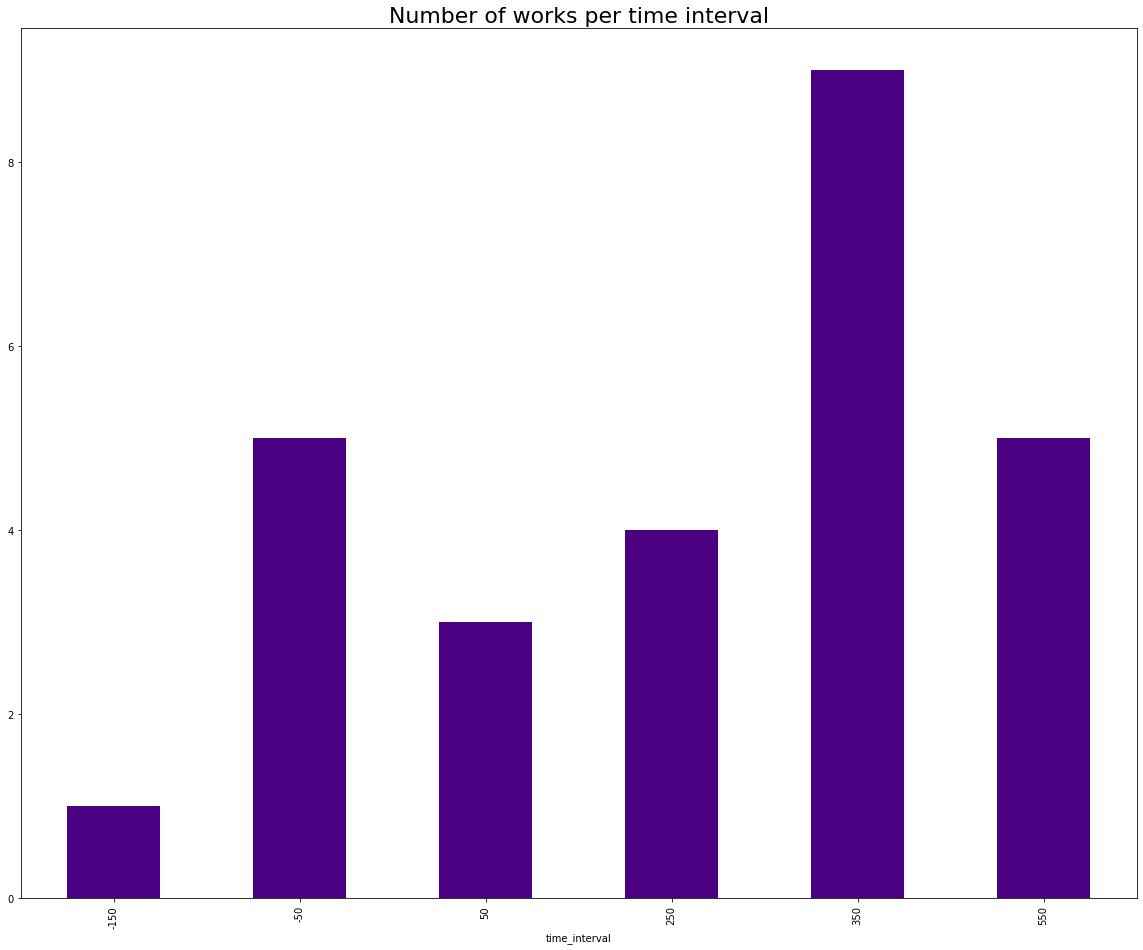

In [140]:
metadata_df0_sel = metadata_df_sel.groupby(['time_interval']).count()
metadata_df0_sel = metadata_df0_sel['id']
metadata_df0_sel
ax = metadata_df0_sel.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

There are:

In [265]:
n_intervals_sel = round((max(metadata_df_sel['time_interval'])-min(metadata_df_sel['time_interval']))/size_interval)
n_intervals_sel

7

in the historical subcorpus.

## Training embeddings for the whole subcorpus

#### Stopwords exclusion and further filtering


I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [291]:
corpus_sel = list()
files_corpus_sel = metadata_df_sel
for index, df_line in files_corpus_sel.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus_sel.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus_sel.append(sentences_this_file)

In [292]:
corpus_sel

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

In [293]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose            50  
69           Plinius Gaius, Cecilius Secundus   100  prose            50  
72                                  Eutropius   350  prose           350  
78                       Ammianus Marcellinus   362  prose           350  
89                     Cicero, Marcus Tullius   -55  prose          -150  
97                              Livius, Titus    -1  prose           -50  
98                 Velleius Paterculus, Caius    29  prose           -50  
118                                  Iordanes   550  prose           550  
120                 Iustinus Iunianus, Marcus   250  prose           250  
142                         [Auctor incertus]   -49  prose           -50  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose           -50  
182                    Curtius Rufus, Quintus    50  prose            50  
236                        Severus, Sulpicius   403  prose           350  
382                        Severus, Sulpicius   350  prose           350  
451                                Hieronymus   390  prose           350  
472                      Augustinus, Aurelius   419  prose           350  
478                       Hydatius Lemicensis   350  prose           350  
482                      Gregorius Turonensis   550  prose           550  
490                         Marcellinus Comes   550  prose           550  
535                     Actorius Naso, Marcus   -49  prose           -50  
536        Auctor incertus (Aurelius Victor?)   350  prose           350  
551                                Hieronymus   400  prose           350  
557                                  Ablabius   330  prose           250  
563              Gargilius Martialis, Quintus   260  prose           250  
572                                  Iordanes   550  prose           550  
575            Isidorus Hispalensis Episcopus   598  prose           550  
611                     Cor

In [294]:
metadata_df_sel.shape

(27, 6)

In [295]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [296]:
start = time.time()
model_sel = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus_sel)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 19 seconds


Let's see what words are similar to "dies":

In [297]:
model_sel.wv.similar_by_word('dies', 10)

[('ann', 0.7278189063072205),
 ('annus', 0.6730678677558899),
 ('hora', 0.6341251134872437),
 ('mensis', 0.6317445039749146),
 ('nox', 0.6148778796195984),
 ('tempus', 0.5915418863296509),
 ('lux', 0.5893463492393494),
 ('mensa', 0.5873286724090576),
 ('annona', 0.5808016657829285),
 ('facies', 0.5783018469810486)]

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [298]:
intervals_sel = [None]*(n_intervals_sel+1)
for t in range(n_intervals_sel+1):
    print(t)
    if t == 0:
        intervals_sel[t] = min(metadata_df_sel['time_interval'])
    else:
        intervals_sel[t] = intervals_sel[t-1]+size_interval
    print(intervals_sel[t])
    
print(intervals_sel)

0
-150
1
-50
2
50
3
150
4
250
5
350
6
450
7
550
[-150, -50, 50, 150, 250, 350, 450, 550]


In [299]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus_sel = dict()

# I loop over all time intervals:
for t in range(n_intervals_sel+1):
    files_corpus_sel_t = metadata_df_sel.loc[metadata_df_sel['time_interval'] == intervals_sel[t]]
    #print("1:",t, files_corpus_sel_t, type(files_corpus_t))
    corpus_sel_t = list()
    for index, df_line in files_corpus_sel_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_sel_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus_sel[t] = corpus_sel_t


In [300]:
time2corpus_sel

{0: [['de',
   'provincia',
   'consularis',
   'si',
   'quis#2',
   'vos',
   'pater',
   'conscribo',
   'exspecto',
   'quis#2',
   'sum',
   'provincia',
   'decerno',
   'considero',
   'ipse',
   'se',
   'cum',
   'quis#2',
   'ego',
   'homo',
   'ex',
   'provincia',
   'potissimus',
   'detraho',
   'sum',
   'non',
   'dubito',
   'quis#2',
   'sentio',
   'ego',
   'convenio',
   'cum',
   'quis#2',
   'ego',
   'sentio',
   'necesse',
   'sum',
   'cogitarit'],
  ['atque',
   'si',
   'princeps',
   'is',
   'sententia',
   'dico',
   'laudo',
   'profecto',
   'si',
   'solus',
   'certus',
   'ignosceritis',
   'etiamsi',
   'paulum',
   'parvus',
   'utilis',
   'vos',
   'sententia',
   'video',
   'venio',
   'tamen',
   'aliquis',
   'dolor',
   'meus',
   'tribuo'],
  ['nunc',
   'verus',
   'pater',
   'conscribo',
   'non',
   'parvus',
   'adficior',
   'voluptas',
   'vel',
   'quod',
   'hic',
   'multus',
   'reus',
   'publicus',
   'conduco',
   'Syria',
  

Let's inspect the corpus for the first time interval:

In [301]:
time2corpus_sel[0]

[['de',
  'provincia',
  'consularis',
  'si',
  'quis#2',
  'vos',
  'pater',
  'conscribo',
  'exspecto',
  'quis#2',
  'sum',
  'provincia',
  'decerno',
  'considero',
  'ipse',
  'se',
  'cum',
  'quis#2',
  'ego',
  'homo',
  'ex',
  'provincia',
  'potissimus',
  'detraho',
  'sum',
  'non',
  'dubito',
  'quis#2',
  'sentio',
  'ego',
  'convenio',
  'cum',
  'quis#2',
  'ego',
  'sentio',
  'necesse',
  'sum',
  'cogitarit'],
 ['atque',
  'si',
  'princeps',
  'is',
  'sententia',
  'dico',
  'laudo',
  'profecto',
  'si',
  'solus',
  'certus',
  'ignosceritis',
  'etiamsi',
  'paulum',
  'parvus',
  'utilis',
  'vos',
  'sententia',
  'video',
  'venio',
  'tamen',
  'aliquis',
  'dolor',
  'meus',
  'tribuo'],
 ['nunc',
  'verus',
  'pater',
  'conscribo',
  'non',
  'parvus',
  'adficior',
  'voluptas',
  'vel',
  'quod',
  'hic',
  'multus',
  'reus',
  'publicus',
  'conduco',
  'Syria',
  'Macedoniamque',
  'decerni',
  'ut',
  'dolor',
  'meus',
  'nihil',
  'ab',
  'c

And the second:

In [302]:
time2corpus_sel[1]

[['Facturusne',
  'opera',
  'pretium',
  'sum',
  'si',
  'ab',
  'primordium',
  'urbs',
  'res',
  'populus#2',
  'Romanus',
  'perscribo',
  'nec',
  'satis',
  'scio',
  'nec',
  'si',
  'scio',
  'dico#2',
  'ausim',
  'quippe',
  'quis#2',
  'cum',
  'vetus',
  'tum',
  'vulgo',
  'sum',
  'res',
  'video',
  'dum',
  'nosco',
  'semper',
  'scriptor',
  'aut',
  'in',
  'res',
  'certus',
  'aliquis',
  'affero',
  'se',
  'aut',
  'scribo',
  'ars',
  'rudis',
  'vetustas',
  'supero',
  'credo'],
 ['Utcumque',
  'sum',
  'iuvo',
  'tamen',
  'res',
  'gero',
  'memoria',
  'princeps',
  'terra',
  'populus#2',
  'pro',
  'virilis',
  'pars',
  'et',
  'ipse',
  'consulo',
  'et',
  'si',
  'in',
  'tantus',
  'scriptum',
  'turba',
  'meus',
  'fama',
  'in',
  'obscurum',
  'sum',
  'nobilitas',
  'atque',
  'magnitudo',
  'is',
  'ego',
  'quis#2',
  'nomen',
  'officio',
  'meus',
  'consolo'],
 ['res',
  'sum',
  'praeterea',
  'et',
  'immensum',
  'opus',
  'ut',
  'qui

And the fourth:

In [303]:
time2corpus_sel[3]

[]

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

In [304]:
len(time2corpus_sel)

8

In [305]:
models_sel = list()
start = time.time()
for t in range(len(time2corpus_sel)):
    if len(time2corpus_sel[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model_sel = FastText(vector_size=100, window=4, min_count=2, workers=1, seed=1,hashfxn=hash)  # instantiate
        model_sel.build_vocab(corpus_iterable=time2corpus_sel[t])
        model_sel.train(corpus_iterable=time2corpus_sel[t], total_examples=len(time2corpus_sel[t]), epochs=10)  # train
        models_sel.append(model_sel)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
    else:
        models_sel.append("")
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
4
5
7
It has taken 100 seconds, or  2 minutes


Let's check some models:

In [306]:
print_vocab(models_sel[0], 20)

word #0/548 is sum
word #1/548 is quis#2
word #2/548 is et
word #3/548 is non
word #4/548 is in
word #5/548 is ille
word #6/548 is ego
word #7/548 is is
word #8/548 is hic
word #9/548 is atque
word #10/548 is si
word #11/548 is cum
word #12/548 is publicus
word #13/548 is ut
word #14/548 is sed
word #15/548 is ab
word #16/548 is possum
word #17/548 is quod
word #18/548 is meus


In [307]:
print_vocab(models_sel[3], 20)

Empty model!


In [308]:
models_sel[3].wv.similar_by_word('dies', 10)

AttributeError: 'str' object has no attribute 'wv'

In [309]:
models_sel[4].wv.similar_by_word('dies', 10)

[('rabies', 0.9999300837516785),
 ('acies', 0.9999269247055054),
 ('exinde', 0.999926745891571),
 ('inluvies', 0.9999203085899353),
 ('inde', 0.9999198317527771),
 ('inquies', 0.9999193549156189),
 ('planities', 0.9999181628227234),
 ('proinde', 0.9999117255210876),
 ('unde', 0.9999098181724548),
 ('pernicies', 0.9999083876609802)]

##  Embedding space alignment

I align all models:

In [310]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, [m for m in models_sel if m != ''])
    

538 538
538 538
['sum', 'et', 'in', 'is', 'quis#2', 'ad', 'cum', 'ab', 'ut', 'se', 'Romanus', 'non', 'omnis', 'atque', 'ex', 'hic', 'quam#4', 'consul', 'res', 'suus', 'facio', 'ipse', 'bellum', 'quod', 'hostis', 'urbs', 'nec', 'per', 'si', 'habeo', 'alius', 'possum', 'sed', 'dies', 'exercitus', 'primus', 'aut', 'de', 'do', 'multus', 'miles', 'senatus', 'iam', 'ne#2', 'magnus', 'mitto', 'idem', 'venio', 'annus', 'pars', 'ita', 'legatus', 'locus', 'video', 'animus', 'pater', 'tum', 'etiam', 'duo', 'deinde', 'ille', 'unus', 'dico#2', 'quo', 'quoque', 'ante', 'M.', 'plebs', 'publicus', 'tribunus', 'qui', 'neque', 'L.', 'tempus', 'ego', 'populus', 'pro', 'tantus', 'arma', 'C.', 'vis', 'causa', 'ago', 'vos', 'modus', 'nihil', 'accipio', 'signum', 'praesidium', 'gero', 'alter', 'peto', 'quia', 'homo', 'socius', 'imperium', 'civitas', 'provincia', 'tamen', 'magis', 'P.', 'consilium', 'pax', 'fero', 'parvus', 'quidem', 'nullus', 'duco', 'itaque', 'deus', 'enim', 'post', 'quisque', 'nomen', 'vir

Now the models have been aligned and have the same vocabulary:

In [311]:
for i in range(0,len(models_sel)):
    if models_sel[i] != '':
        print(i, len(models_sel[i].wv.index_to_key))

0 464
1 453
2 453
4 453
5 453
7 453


# Semantic change with cosine similarity

In [313]:
intervals_sel

[-150, -50, 50, 150, 250, 350, 450, 550]

In [314]:
models_sel

 '',
 '',

In [337]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index

6

In [338]:
models_sel[4].wv["sum"]

array([-0.31725872,  0.11440333, -0.6305807 ,  0.19707248,  0.1873723 ,
       -0.2073971 , -0.23309346,  0.20965454,  0.1350249 , -0.20576175,
        0.39579254, -0.41094172, -0.34271857, -0.2557472 , -0.5508051 ,
       -0.2938961 ,  0.21812208, -0.43543133, -0.5244981 ,  0.29689944,
        0.03406845, -0.5783716 ,  0.235912  , -0.08456314,  0.8112199 ,
        0.32819888,  0.12310205, -0.62652856, -0.2572849 ,  0.07358547,
        0.61046493, -0.4068147 ,  0.30743816,  0.11374743,  0.05540456,
       -0.41288462,  0.2672211 ,  0.6371753 , -0.5155078 , -0.03743447,
        0.5703212 , -0.4045757 ,  0.5666739 , -0.13402939, -0.523578  ,
       -0.05641046, -0.02758892, -0.53545654,  0.0087245 , -0.8317165 ,
        0.13708618, -0.4180579 , -0.69371915,  0.09560488, -1.5268651 ,
       -0.3009386 ,  0.20441091, -0.19432554, -0.6088105 , -0.39807302,
        0.35994178,  0.6401788 ,  0.4439411 , -0.57696134,  0.16162397,
        0.00231675,  0.39030394,  0.16219945,  0.7041826 ,  0.21

In [339]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index
#cosine_similarity("sum", 4, "last", models_sel)

6

In [340]:
cosine_similarity("sum", 4, "first", models_sel)

TypeError: cosine_similarity() missing 1 required positional argument: 'intervals'

In [341]:
models_sel

 '',
 '',

In [347]:
cosine_similarity_dataframe("last", 0, models_sel, intervals_sel)

6
The reference model or the current model are empty!


Empty DataFrame
Columns: []
Index: []

In [355]:
cosine_similarity_dataframe("last", 8, models_sel, intervals_sel)

Second argument needs to be between 0 and  7
6
The reference model or the current model are empty!


Empty DataFrame
Columns: []
Index: []

Visualise the distribution of the semantic similarity scores with a histogram:

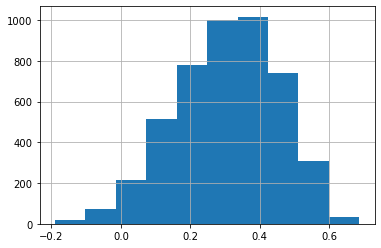

In [63]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [ ]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step)
time_series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
for i in range(len(models)-1):
    #print(reference_interval_index)
    #print("Interval", str(range_intervals[i]))
    #print((list(range_intervals)))
    print("Interval", str(range_intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i)
    if i == 0:
        time_series_df = df
        col_i = "interval-"+str(0)
        time_series_df[col_i] = [0 for w in models[reference_interval_index].wv.index_to_key]
        col_n = "neighbours_ref-"+reference_step
        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
    else:
        #time_series_df = time_series_df, df.iloc[:,-2:]
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(tmp_df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
        
    #print(time_series_df)
    
time_series_df

In [ ]:
time_series_df.columns

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

In [ ]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

In [ ]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
               ]].iloc[0]

In [ ]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [ ]:
plt.scatter([0,1,2,3], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [ ]:
time_series_df.columns

In [ ]:
time_series_df

In [ ]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1

List of socio-political terms:

In [ ]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [ ]:
time_series_df_socpol = time_series_df1[time_series_df1['Word'].isin(socio_political_terms)]
time_series_df_socpol

In [ ]:
for i in range(len(socio_political_terms)):
    plt.scatter([0,1,2,3], 
            time_series_df_socpol[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)',
                           'Cosine_similarity(w_t_reference-last,w_t2)',
                           'Cosine_similarity(w_t_reference-last,w_t3)'
                           ]].iloc[i])
plt.show()

In [387]:
px.line(time_series_df_socpol)

OLD CODE

Now I sort by decreasing semantic change score:

In [ ]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

I add the total frequency:

In [ ]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

In [ ]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
cosine_similarity_df_sorted.head(100)

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="scientist"]

I plot the terms by their total frequency and semantic change score:

In [ ]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

I exclude the outliers:

In [ ]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

Plot:

In [ ]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


In [ ]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

In [ ]:
min(cosine_similarity_chosen.Cosine_similarity)

In [ ]:
min(cosine_similarity_chosen.Total_Frequency)

In [ ]:
min(cosine_similarity_df_sorted.Cosine_similarity)

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [ ]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

Which words are these words?

In [ ]:
cosine_similarity_df_sorted_filtered

Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

I create a list for these words:

In [ ]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

Now I annotate the plot with these:

In [ ]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

In [ ]:
model = sg_w5_f1
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [ ]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [ ]:
print(str(len(vocab_filtered)))

Distribution of filtered word frequencies:

In [ ]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [ ]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

In [ ]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

Visualise the distribution of the semantic change scores with a histogram:

In [ ]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [ ]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

I add the total frequency:

In [ ]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

I integrate the neighbour score in the file:

In [ ]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

I plot the terms by two semantic change scores:

In [ ]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [ ]:
semantic_change_2methods_all.corr(method="spearman")

There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [ ]:
semantic_change_2methods_all.describe()

Scores for chosen words:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Scores for not chosen words:

In [ ]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Compare the two means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

I define a list of words that I expect did not change:

In [ ]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Let's look at species:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

I compare the means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [ ]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [ ]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [ ]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()